# Australian Boreholes

Looking at the data from the [**Australian Borehole Stratigraphic Unit Compilation**](https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/147641) 2023 v1.0

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import pygmt
from joblib import Parallel, delayed
import requests
import zipfile
import io
import os
from shapely import Point
from tqdm import tqdm
import re
from copy import copy
import geodatasets
from shapely import Polygon

from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException, NoSuchElementException

In [2]:
absuc = pd.read_csv("../data/ABSUC/ABSUC_v1_BASE.txt")  # preferred stratigraphic picks for the base of each unit
absuc.set_index("GA_GUID", inplace=True)
# remove entries with NaNs in the seemingly relevant depth measurements
absuc.dropna(
    axis=0,
    subset=("TD_MD_M", "TOP_MD_M", "BASE_MD_M", "TOP_AHD_M", "BASE_AHD_M", "GA_ASUD_NO"),
    inplace=True,
)

# remove some irrelevant columns
absuc.drop(
    labels=[
        "OBJECTID",
        "GA_ENO",
        "UWI",
        "GL_AHD_M",
        "WD_AHD_M",
        "SRTM_HE_AHD_M",
        "DATUM_ELEVATION_AHD_M",
        "GA_HYDROSTRAT",
        "TAG",
        "Z_M_SRTM",
        "COMMENT",
    ],
    axis=1,
    inplace=True
)

# create geometry
absuc["geometry"] = absuc.apply(lambda x: Point(x.GDA94_LONGITUDE, x.GDA94_LATITUDE), axis=1)
absuc = gpd.GeoDataFrame(absuc)

/var/folders/3z/q924mq751jgf5h_73dyy3vx0gyx48k/T/ipykernel_96833/1615743922.py:1: DtypeWarning: Columns (4,28) have mixed types. Specify dtype option on import or set low_memory=False.
  absuc = pd.read_csv("../data/ABSUC/ABSUC_v1_BASE.txt")  # preferred stratigraphic picks for the base of each unit


Scrape Australian Stratigraphic Units Database to determine if a unit is sedimentary

In [3]:
class ASUDScraper:
    """
    A simple scraper, the purpose of which is to determine if a geological unit
    is in a sedimentary province
    """
    def __init__(self, timeout=60):
        self.base_url = "https://asud.ga.gov.au/search-stratigraphic-units/results/"
        self.initalise_driver(timeout)
        self.timedout_units = []

    def initalise_driver(self, timeout):
        options = Options()
        options.headless = True
        self.driver = webdriver.Chrome(ChromeDriverManager().install(), options=options)
        self.wait = WebDriverWait(self.driver, timeout=timeout)

    def get_unit(self, asud_no):
        """
        input: asud_no - unique identifier for the Australian
        Stratigraphic Units Database
        """
        self.driver.get(f"{self.base_url}{asud_no}")
        try:
            # wait for the span that contains either a link to the Geological Province
            # or just some text if no provice is found
            span = self.wait.until(lambda driver: driver.find_element(By.XPATH, "//ga-search-stratigraphic-units-results-details/div/div/div[2]/table/tbody/tr[3]/td[2]/div/span"))
            link = span.find_element(By.XPATH, "./a")
            return link
        except TimeoutException:
            self.timedout_units.append(asud_no)
            return None
        except NoSuchElementException:
            return None
    
    def is_sedimentary(self, asud_no):
        link = self.get_unit(asud_no)
        if link is None:
            return False
        link.click()
        try:
            table = self.wait.until(lambda driver: driver.find_element(By.XPATH, "//ga-geological-province/div/div[1]/div[1]/table"))
            row = table.find_element(By.XPATH, ".//tbody/tr[last()]")
        except TimeoutException:
            self.timedout_units.append(asud_no)
            return False
        except NoSuchElementException:
            return False
        
        try:
            sedimentary = re.search("Type:\s+sedimentary", row.text)
        except UnboundLocalError: # no row found
            sedimentary = False

        return True if sedimentary else False
    
    def cleanup(self):
        self.driver.close()
        


In [4]:
fname = "../data/ABSUC/sedimentary_units.txt"
if os.path.exists(fname):
    sedimentary_units = np.loadtxt(fname)
else:
    def get_sedimentary_units(units):
        scraper = ASUDScraper(timeout=20)
        sedimentary = [unit for unit in tqdm(units) if scraper.is_sedimentary(unit)]
        timedout = copy(scraper.timedout_units)
        scraper.cleanup()
        return sedimentary, timedout

    asud_nos = absuc["GA_ASUD_NO"].unique()
    asud_nos = asud_nos[~np.isnan(asud_nos)].astype(int)
    sedimentary_units, timedout = get_sedimentary_units(asud_nos)

In [5]:
# add a column to absuc for sedimentary or not
absuc["SEDIMENTARY"] = False
absuc.loc[absuc["GA_ASUD_NO"].isin(sedimentary_units),"SEDIMENTARY"] = True

In [6]:
def drop_offshore(points):
    """
    Removes points that are not in mainland Australia or Tasmania

    :param points: GeoDataBase
    """
    NE = gpd.read_file(geodatasets.get_path("naturalearth land"))
    _rough = Polygon(((112, -46), (112, -8), (155, -8), (155, -46)))
    _region = NE[NE.within(_rough)]
    aus = _region[
        _region.scalerank == 0
    ]  # not sure what `scalerank` means but it works - finds continent and TAS
    return points[
        points.within(aus.iloc[0].geometry) | points.within(aus.iloc[1].geometry)
    ]
   

In [7]:
# create a smaller dataframe with just the necessary borehole data

fname = os.path.join("..", "data", "ABSUC", "boreholes.geojson")
if not os.path.exists(fname):
    boreholes = gpd.GeoDataFrame(absuc.drop_duplicates("GA_BOREHOLE_GUID"))
    boreholes.set_index("GA_BOREHOLE_GUID", inplace=True)
    boreholes = boreholes.loc[
        :, ("BOREHOLE_NAME", "GDA94_LATITUDE", "GDA94_LONGITUDE", "geometry")
    ]

    # Drop offshore boreholes
    boreholes = drop_offshore(boreholes)

    # determine borehole depth to basement
    boreholes["BASEMENT_DEPTH"] = 0
    boreholes["BOTTOM"] = False  # If True, depth picked was the last layer
    for borehole_id in tqdm(boreholes.index):
        units = absuc[absuc["GA_BOREHOLE_GUID"] == borehole_id].copy()
        units.sort_values(
            by="BASE_MD_M", axis=0, ascending=False, inplace=True
        )  # BASE_MD_M is depth so largest is bottom
        for i, (_, unit) in enumerate(units.iterrows()):
            if unit["SEDIMENTARY"]:
                boreholes.loc[unit["GA_BOREHOLE_GUID"], "BASEMENT_DEPTH"] = unit[
                    "BASE_MD_M"
                ]
                if i == 0:
                    boreholes.loc[unit["GA_BOREHOLE_GUID"], "BOTTOM"] = True
                break

    boreholes.sort_values(by="BASEMENT_DEPTH", inplace=True)
    boreholes.to_file(fname, driver="GeoJSON")
else:
    boreholes = gpd.read_file(fname)

100%|██████████| 84122/84122 [17:40<00:00, 79.29it/s]


Try a couple boreholes in SA and see if we can estimate something similar to what is given on SARIG

In [8]:
datadir = os.path.join("..", "data", "SA_drillholes")
if not os.path.exists(datadir):
    print("downloading...")
    r = requests.get("https://data.sarig.sa.gov.au/Map/Download/layerDownload?layeId=924&formatLovId=20")
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(path=datadir)
    with open(os.path.join(datadir, ".gitignore"), "w") as f:
        f.write("*")
SA = drop_offshore(gpd.read_file(os.path.join(datadir, "drillholes_depthtobasement.shp")))

In [9]:
def ckdnearest(gdA, gdB):
    from scipy.spatial import cKDTree
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf

_nearest = ckdnearest(SA, boreholes)

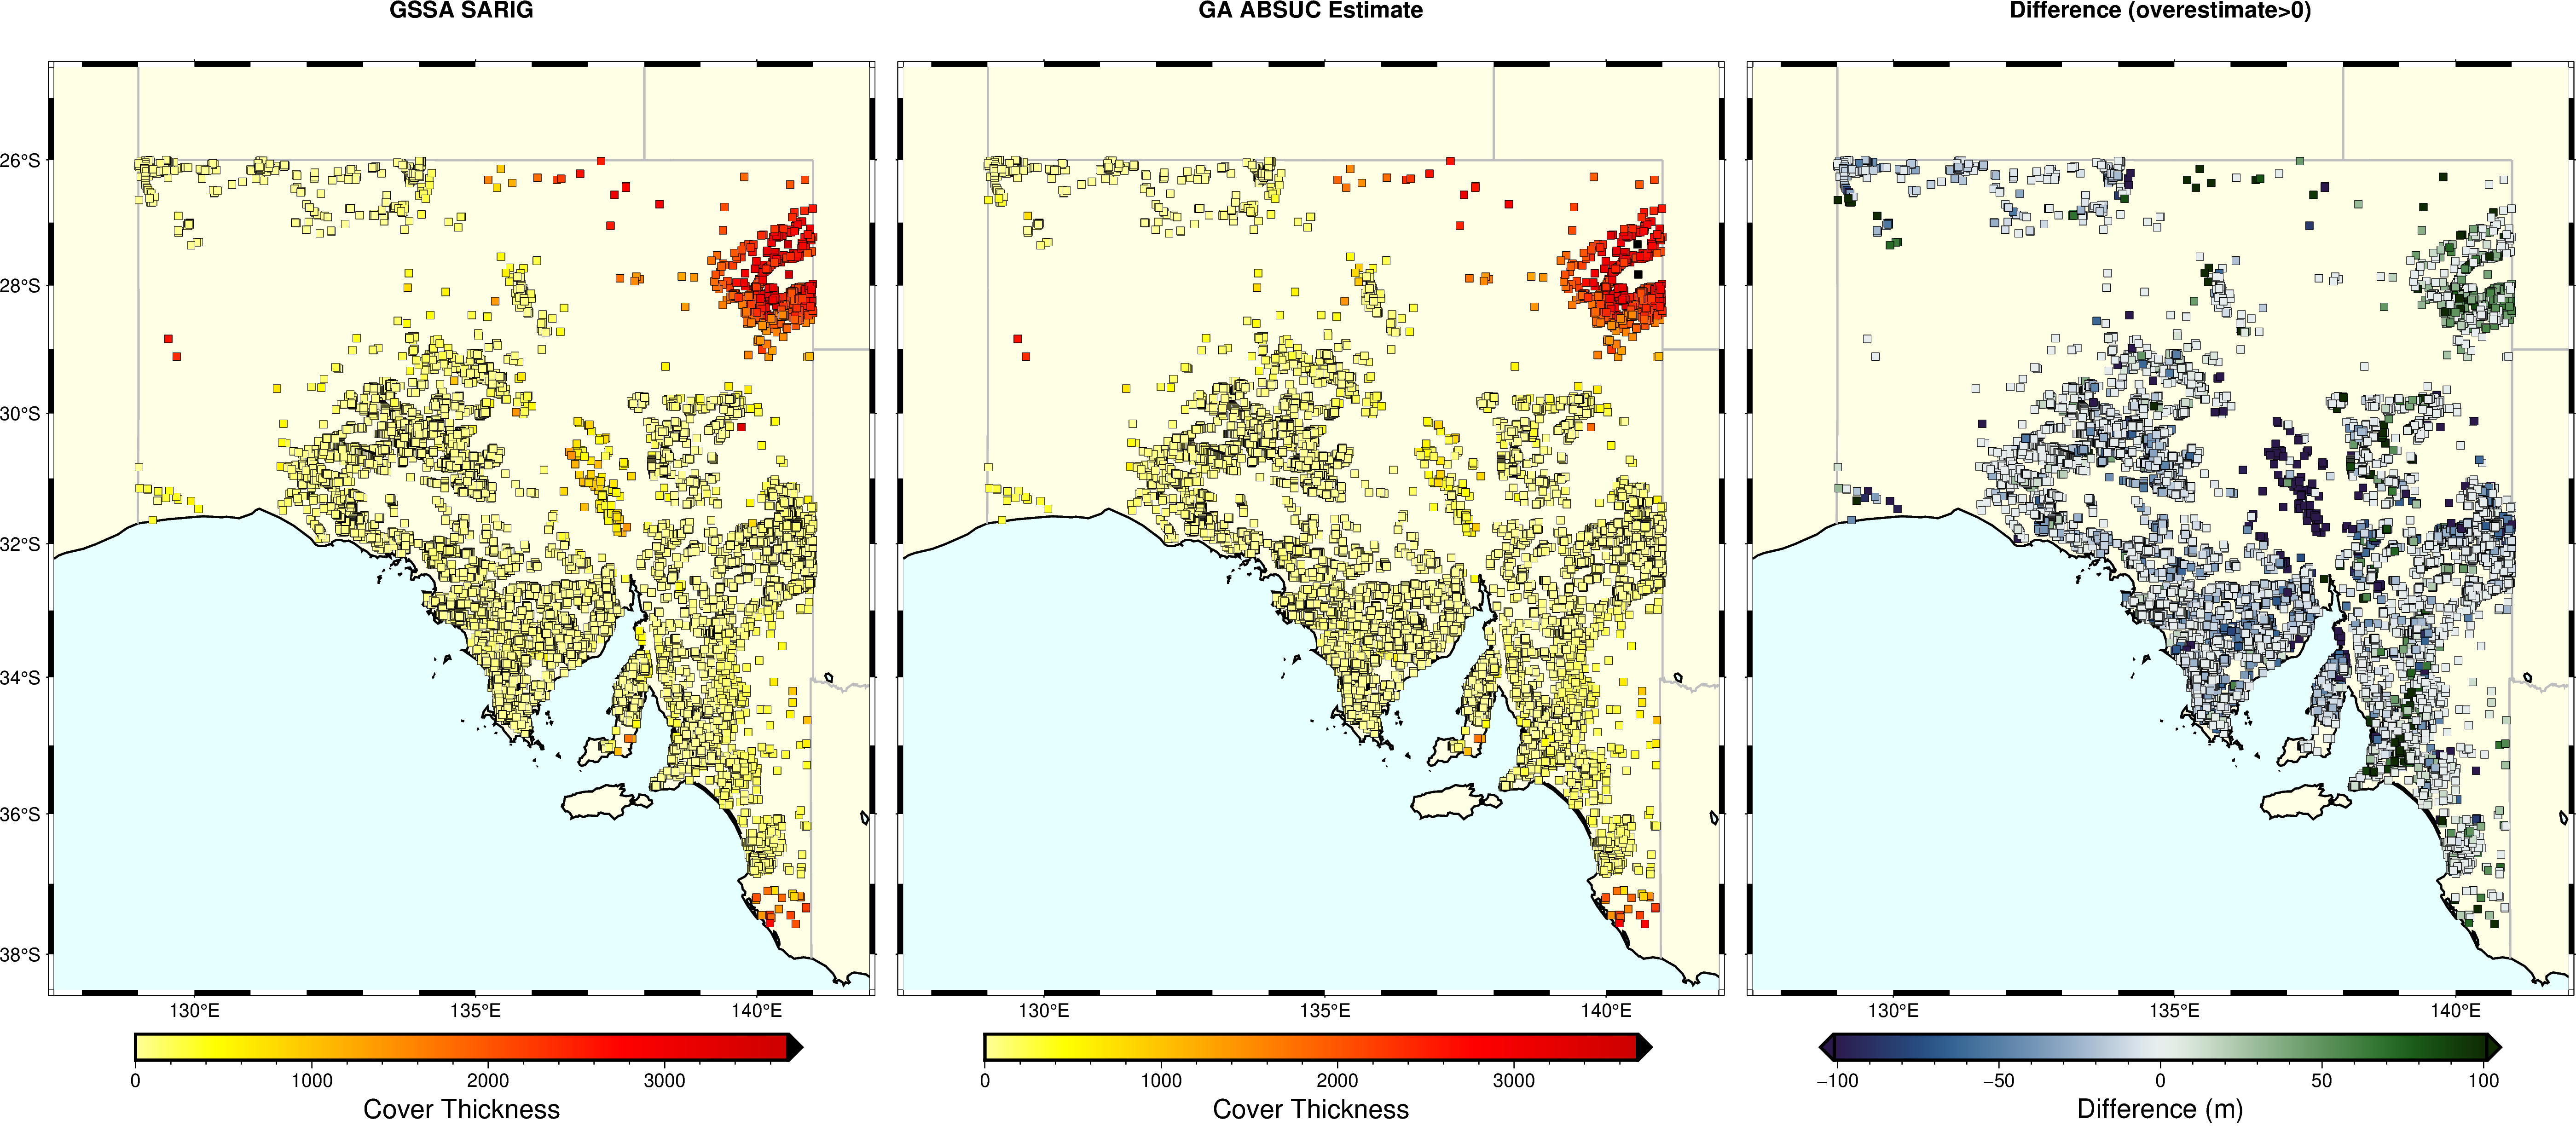

In [10]:
fig = pygmt.Figure()
pygmt.config(FONT_TITLE="12")
ln_min, ln_max = (127.5, 142)
lt_min, lt_max = (-38.5, -24.5)
region = [ln_min, ln_max, lt_min, lt_max]
_width = 15
projection = f"M12/11/{_width}c"
x = _nearest.ADJGDA94_X
y = _nearest.ADJGDA94_Y

def _base_fig(fig, frame):
    fig.basemap(region=region, frame=frame, projection=projection)
    fig.coast(
        shorelines=1,
        land="#ffffe6",
        water="#e6ffff",
        borders="2/1p,grey",
        projection=projection,
        region=region,
    )
    pygmt.makecpt(
        cmap="hot",
        truncate=[0.3, 0.9],
        series=[SA.COVR_THICK.min(), SA.COVR_THICK.max()],
        reverse=True,
    )
    fig.colorbar(
        region=region,
        projection=projection,
        frame=["af+lCover Thickness"],
        position="JBC+ef",
    )
    return fig


with fig.subplot(
    nrows=1,
    ncols=3,
    subsize=(f"{_width}c", "6c"),
    sharey="l",
    frame="WSne",
):
    with fig.set_panel(0):
        fig = _base_fig(fig, "+tGSSA SARIG")
        fig.plot(
            x=x,
            y=y,
            fill=_nearest.COVR_THICK,
            cmap=True,
            style=f"sc",
            pen="0p",
            size=np.full_like(x, 0.2),
            projection=projection,
            region=region,
        )

    with fig.set_panel(1):
        fig = _base_fig(fig, "+tGA ABSUC Estimate")
        fig.plot(
            x=x,
            y=y,
            fill=_nearest.BASEMENT_DEPTH,
            cmap=True,
            style=f"sc",
            pen="0p",
            size=np.full_like(x, 0.2),
            projection=projection,
            region=region,
        )
    
    with fig.set_panel(2):
        frame = "+tDifference (overestimate>0)"
        fig.basemap(region=region, frame=frame, projection=projection)
        fig.coast(
            shorelines=1,
            land="#ffffe6",
            water="#e6ffff",
            borders="2/1p,grey",
            projection=projection,
            region=region,
        )
        diff = _nearest.BASEMENT_DEPTH - _nearest.COVR_THICK
        _nearest["DIFF"] = diff
        end = 2 * diff.std()
        pygmt.makecpt(
            cmap="cork",
            series=[-end, end],
        ) 
        fig.colorbar(
            region=region,
            projection=projection,
            frame=["af+lDifference (m)"],
            position="JBC+e",
        )      
        fig.plot(
            x=x,
            y=y,
            fill=diff,
            cmap=True,
            style=f"sc",
            pen="0p",
            size=np.full_like(x, 0.2),
            projection=projection,
            region=region,
        )
fig.show()

[Text(0, -5000.0, ''),
 Text(0, -2500.0, ''),
 Text(0, 0.0, ''),
 Text(0, 2500.0, '')]

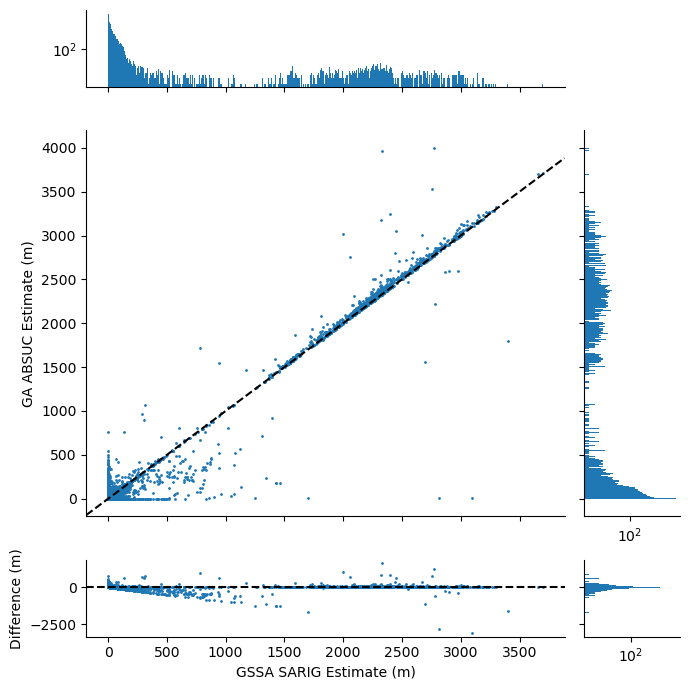

In [ ]:
x = _nearest.COVR_THICK
y = _nearest.BASEMENT_DEPTH
d = _nearest.DIFF
fig, axs = plt.subplots(3, 2, gridspec_kw=dict(height_ratios=[1,5,1], width_ratios=[5,1]), figsize=(7,7), tight_layout=True)

axs[0,0].hist(x, bins=500)
axs[1,0].scatter(x,y,s=1)
axs[1,0].axline((0, 0), slope=1, c="k", ls="--")
axs[1,1].hist(y, bins=500, orientation="horizontal")
axs[2,0].scatter(x, d,s=1)
axs[2,0].axline((0, 0), slope=0, c="k", ls="--")
axs[2,1].hist(d, bins=500, orientation="horizontal")

axs[0,1].set_visible(False)
[ax.spines[["top", "right"]].set_visible(False) for ax in axs.ravel()]

axs[0,0].set_yscale("log")
axs[1,1].set_xscale("log")
axs[2,1].set_xscale("log")

axs[2,0].set_xlabel("GSSA SARIG Estimate (m)")
axs[1,0].set_ylabel("GA ABSUC Estimate (m)")
axs[2,0].set_ylabel("Difference (m)")

axs[0,0].set_xticklabels([])
axs[1,0].set_xticklabels([])
axs[1,1].set_yticklabels([])
axs[2,1].set_yticklabels([])

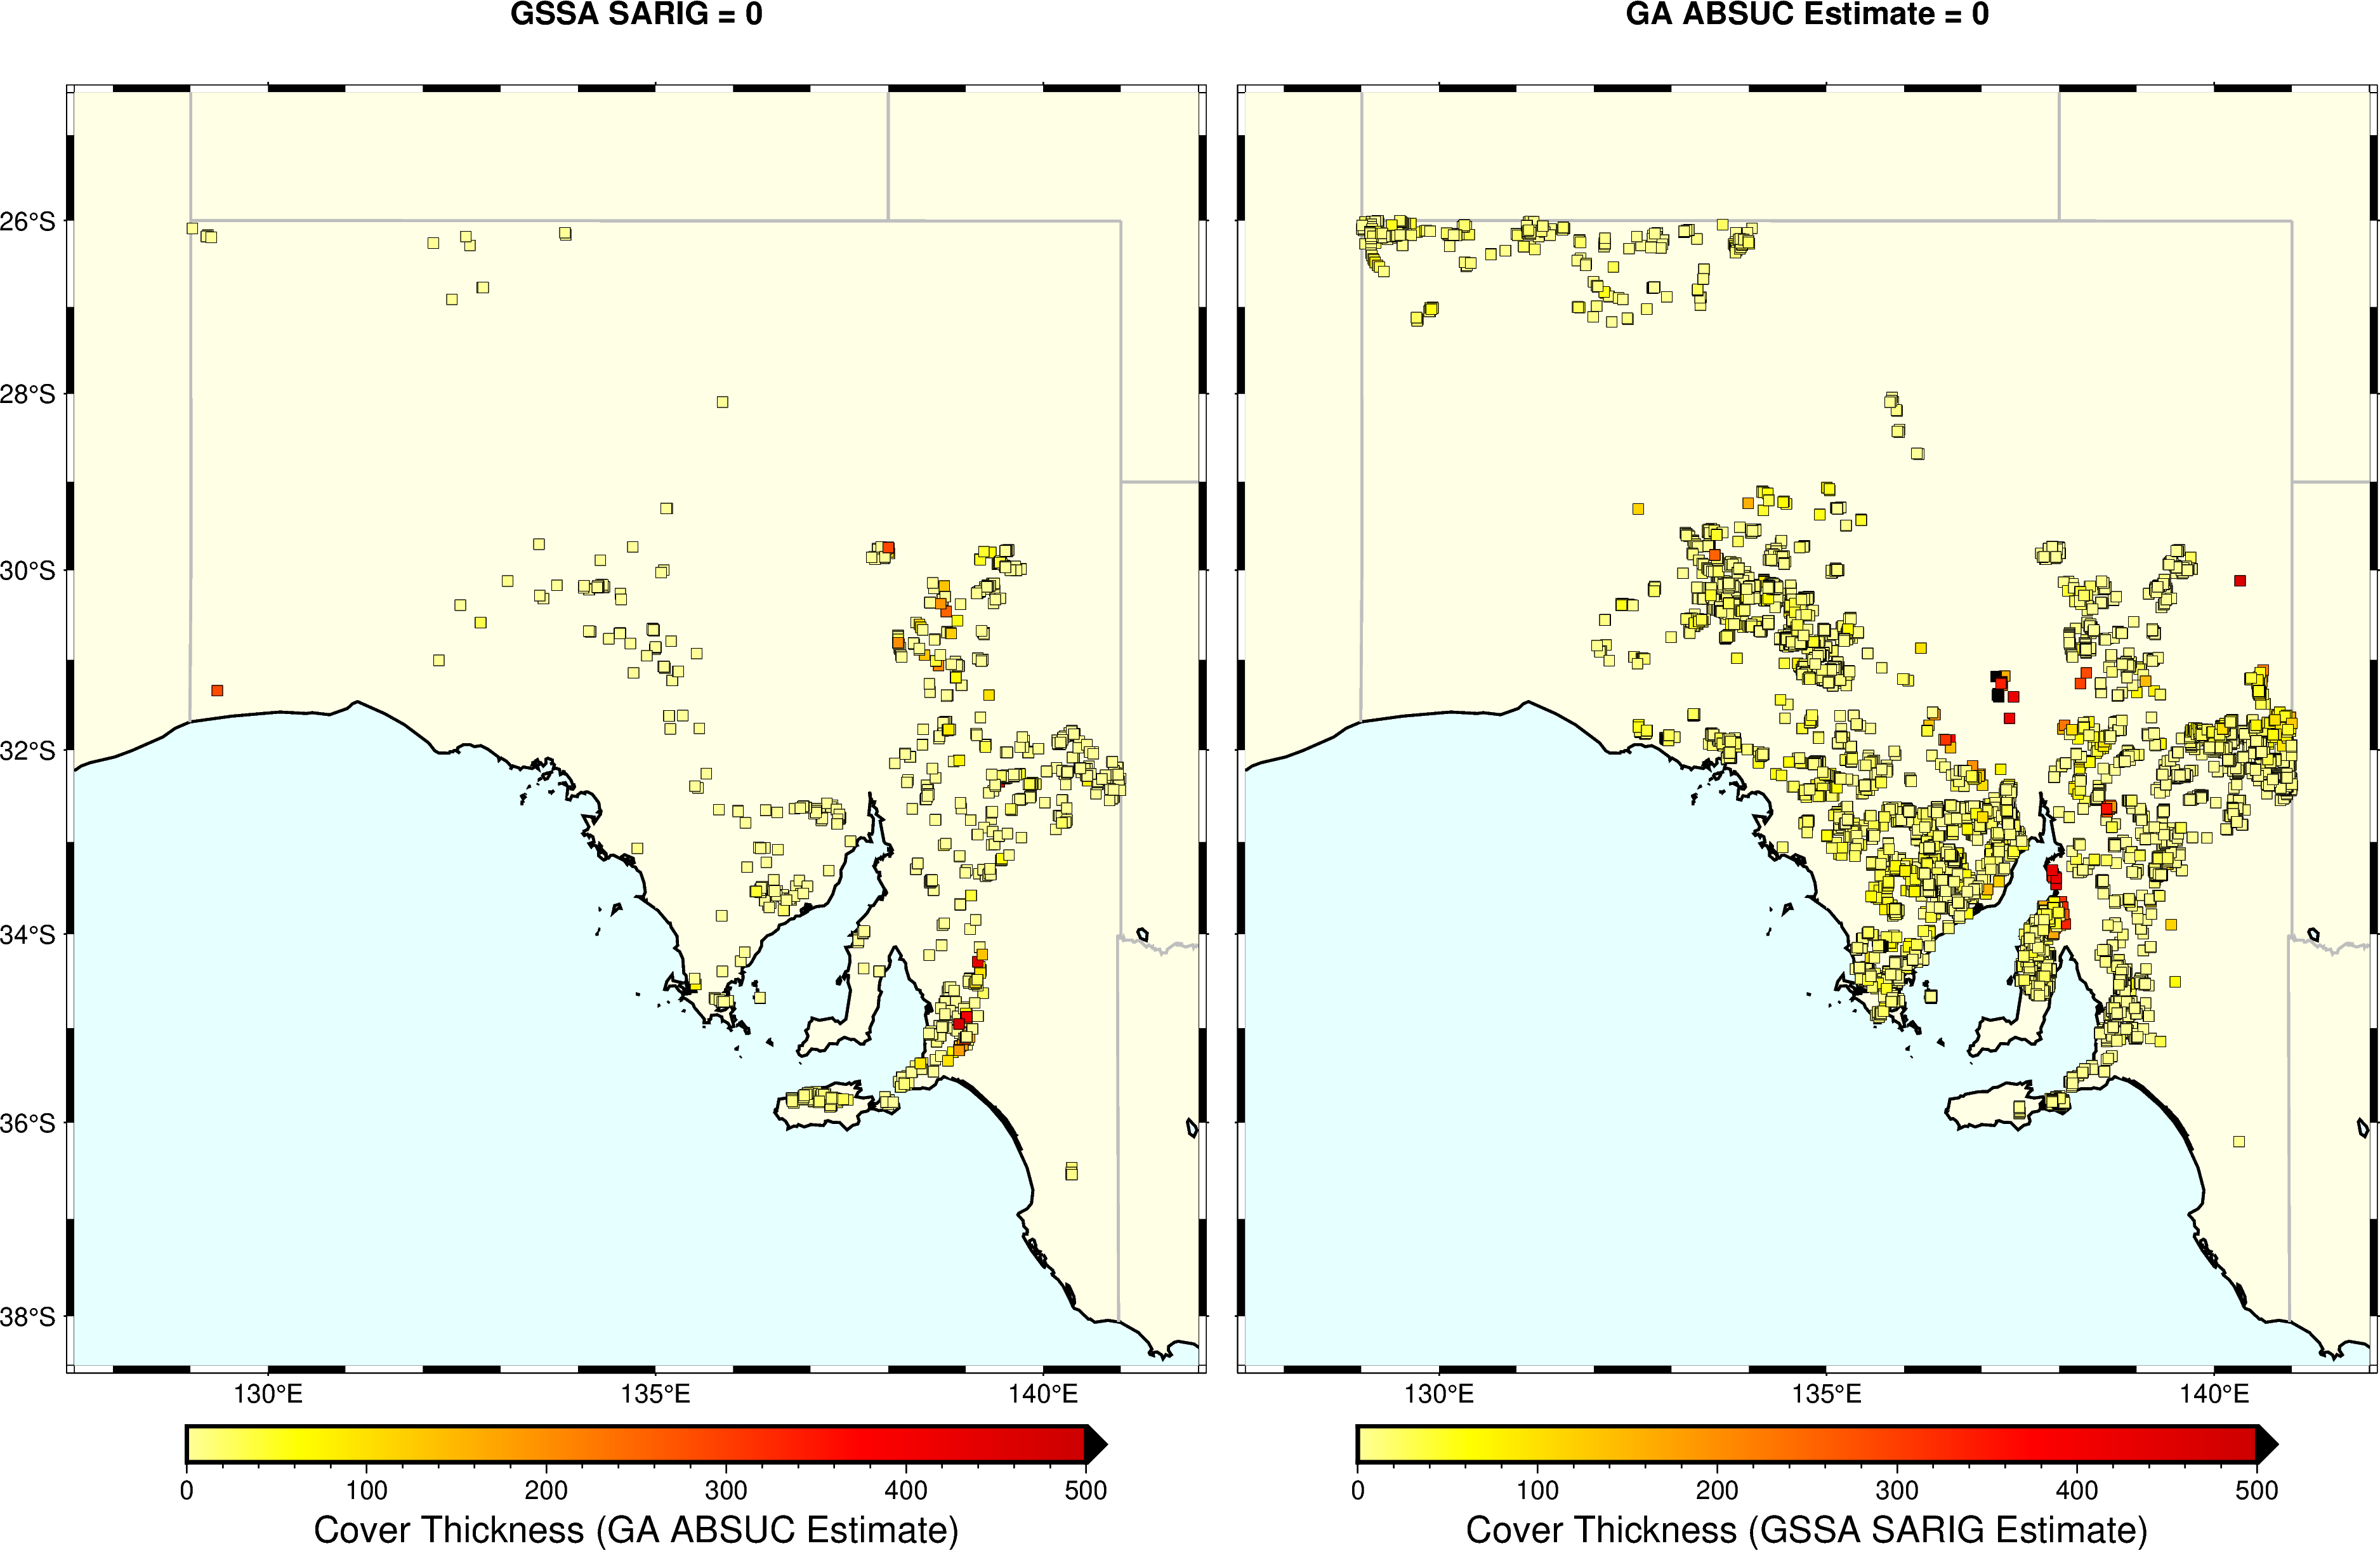

In [ ]:
fig = pygmt.Figure()
pygmt.config(FONT_TITLE="12")
ln_min, ln_max = (127.5, 142)
lt_min, lt_max = (-38.5, -24.5)
region = [ln_min, ln_max, lt_min, lt_max]
_width = 15
projection = f"M12/11/{_width}c"
x = _nearest.ADJGDA94_X
y = _nearest.ADJGDA94_Y

def _base_fig(fig, frame):
    fig.basemap(region=region, frame=frame, projection=projection)
    fig.coast(
        shorelines=1,
        land="#ffffe6",
        water="#e6ffff",
        borders="2/1p,grey",
        projection=projection,
        region=region,
    )
    pygmt.makecpt(
        cmap="hot",
        truncate=[0.3, 0.9],
        series=[0, 500],
        reverse=True,
    )
    return fig


with fig.subplot(
    nrows=1,
    ncols=3,
    subsize=(f"{_width}c", "6c"),
    sharey="l",
    frame="WSne",
):
    with fig.set_panel(0):
        fig = _base_fig(fig, "+tGSSA SARIG = 0")
        x = _nearest[_nearest.COVR_THICK == 0].ADJGDA94_X
        y = _nearest[_nearest.COVR_THICK == 0].ADJGDA94_Y
        fill = _nearest[_nearest.COVR_THICK == 0].BASEMENT_DEPTH
        
        fig.plot(
            x=x,
            y=y,
            fill=fill,
            cmap=True,
            style=f"sc",
            pen="0p",
            size=np.full_like(x, 0.2),
            projection=projection,
            region=region,
        )
        fig.colorbar(
            region=region,
            projection=projection,
            frame=["af+lCover Thickness (GA ABSUC Estimate)"],
            position="JBC+ef",
        )

    with fig.set_panel(1):
        fig = _base_fig(fig, "+tGA ABSUC Estimate = 0")
        x = _nearest[_nearest.BASEMENT_DEPTH == 0].ADJGDA94_X
        y = _nearest[_nearest.BASEMENT_DEPTH == 0].ADJGDA94_Y
        fill = _nearest[_nearest.BASEMENT_DEPTH == 0].COVR_THICK
        fig.plot(
            x=x,
            y=y,
            fill=fill,
            cmap=True,
            style=f"sc",
            pen="0p",
            size=np.full_like(x, 0.2),
            projection=projection,
            region=region,
        )
        fig.colorbar(
            region=region,
            projection=projection,
            frame=["af+lCover Thickness (GSSA SARIG Estimate)"],
            position="JBC+ef",
        )
fig.show()

Text(0.5, 1.0, 'Boreholes ABSUC Estimate = 0')

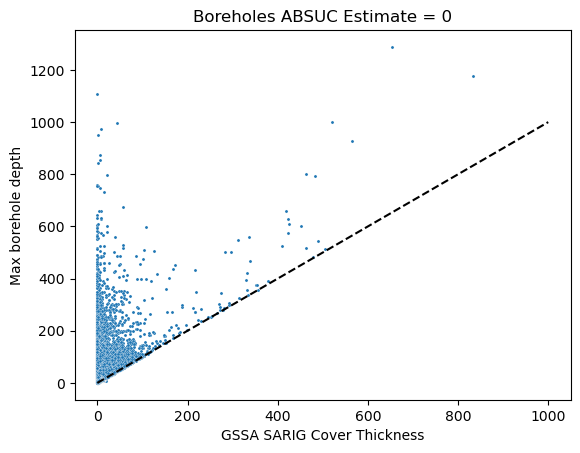

In [ ]:
d = _nearest[_nearest["BASEMENT_DEPTH"] == 0]
ax = sns.scatterplot(data=d, x="COVR_THICK", y="MAX_DEPTH", s=5)
ax.plot([0,1000], [0,1000], "k--")
ax.set_xlabel("GSSA SARIG Cover Thickness")
ax.set_ylabel("Max borehole depth")
ax.set_title("Boreholes ABSUC Estimate = 0")

In [ ]:
d = np.log10(_nearest["dist"])
d.mean(), d.std(), d.min(), d.max()

(-4.467895886947046,
 1.1956382752099892,
 -13.671288541487455,
 0.2962863222898799)

Text(0.5, 1.0, 'GSSA basement estimate = 0')

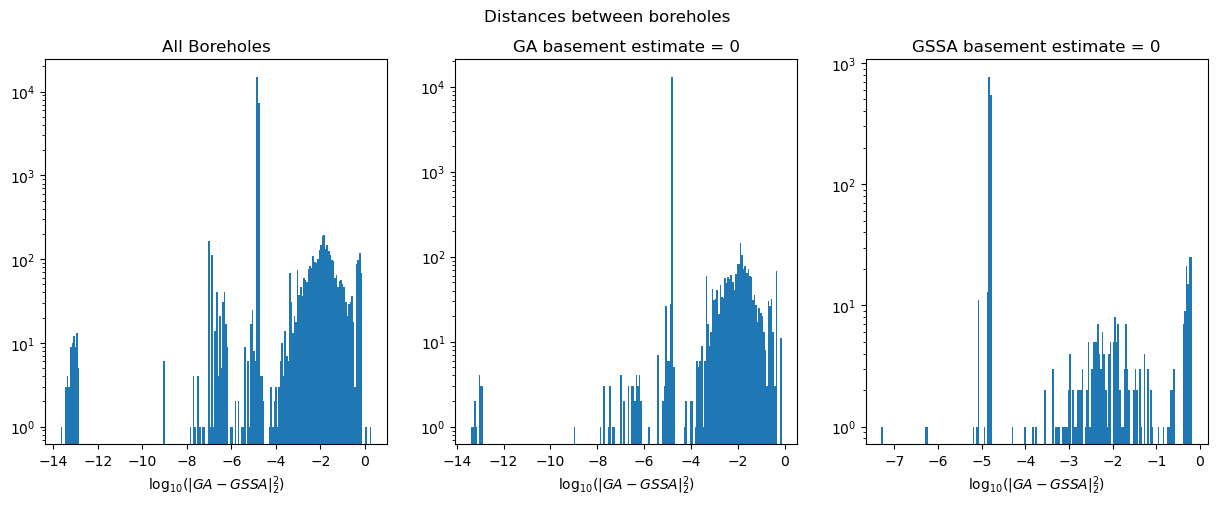

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={"yscale": "log"})
fig.suptitle("Distances between boreholes")
axs[0].hist(d, bins=200)
axs[1].hist(d[_nearest["BASEMENT_DEPTH"] == 0], bins=200)
axs[2].hist(d[_nearest["COVR_THICK"] == 0], bins=200)
[ax.set_xlabel("$\log_{10}(\|GA - GSSA\|_2^2)$") for ax in axs]
axs[0].set_title("All Boreholes")
axs[1].set_title("GA basement estimate = 0")
axs[2].set_title("GSSA basement estimate = 0")

Plot whole continent

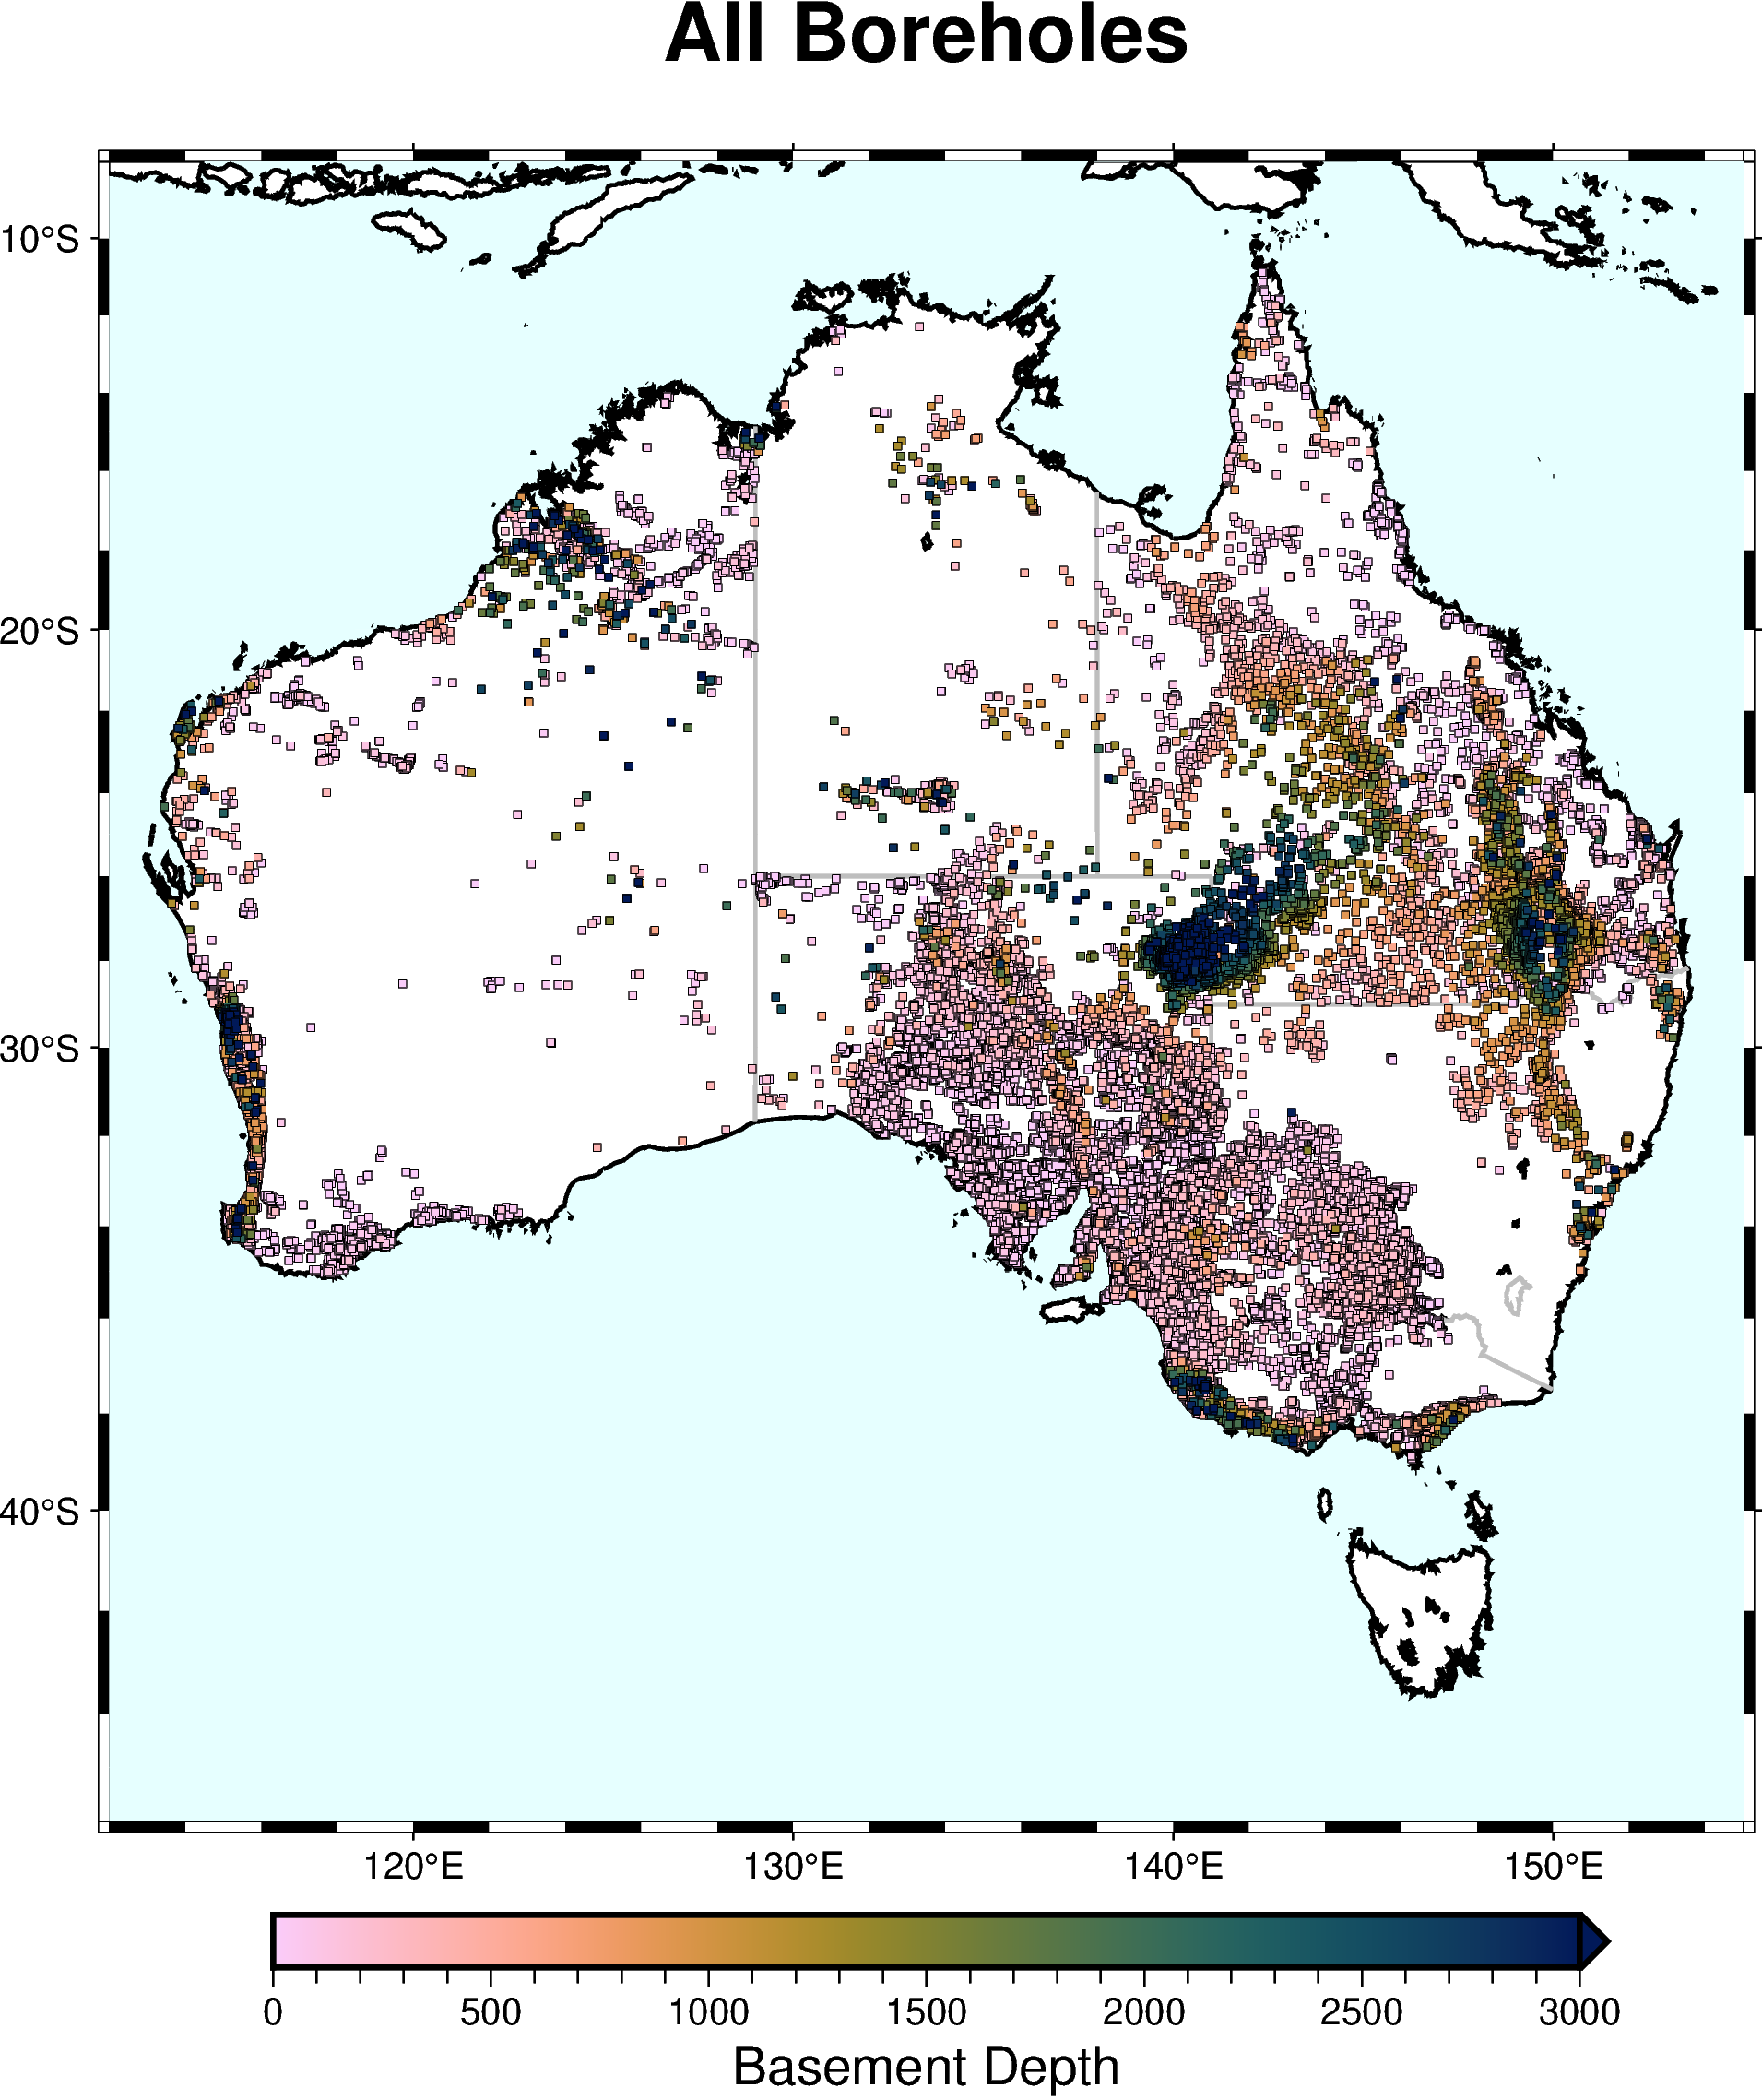

In [ ]:
boreholes.sort_values("BASEMENT_DEPTH", ascending=True, inplace=True)
fig = pygmt.Figure()
fig_width = 15
region = [112, 155, -46, -8]
ln_min, ln_max, lt_min, lt_max = region
projection = (
    f"M{int(np.mean([ln_min, ln_max]))}/{int(np.mean([lt_min, lt_max]))}/{fig_width}c"
)
fig.basemap(region=region, projection=projection, frame=["af", "+tAll Boreholes"])
fig.coast(
    region=region,
    projection=projection,
    shorelines=1,
    resolution="i",
    water="#e6ffff",
    borders="2/1p,grey",
)
pygmt.makecpt(
    cmap="batlow",
    series=[0, round(np.percentile(boreholes.BASEMENT_DEPTH, 99), -3)],
    reverse=True
)
x = boreholes.GDA94_LONGITUDE
y = boreholes.GDA94_LATITUDE
fig.plot(
    region=region,
    projection=projection,
    x=x,
    y=y,
    fill=boreholes.BASEMENT_DEPTH,
    cmap=True,
    style=f"sc",
    pen="0p",
    size=np.full_like(x, 0.1),
)
fig.colorbar(
    region=region,
    projection=projection,
    frame=["af+lBasement Depth"],
    position="JBC+ef",
)
fig.show()

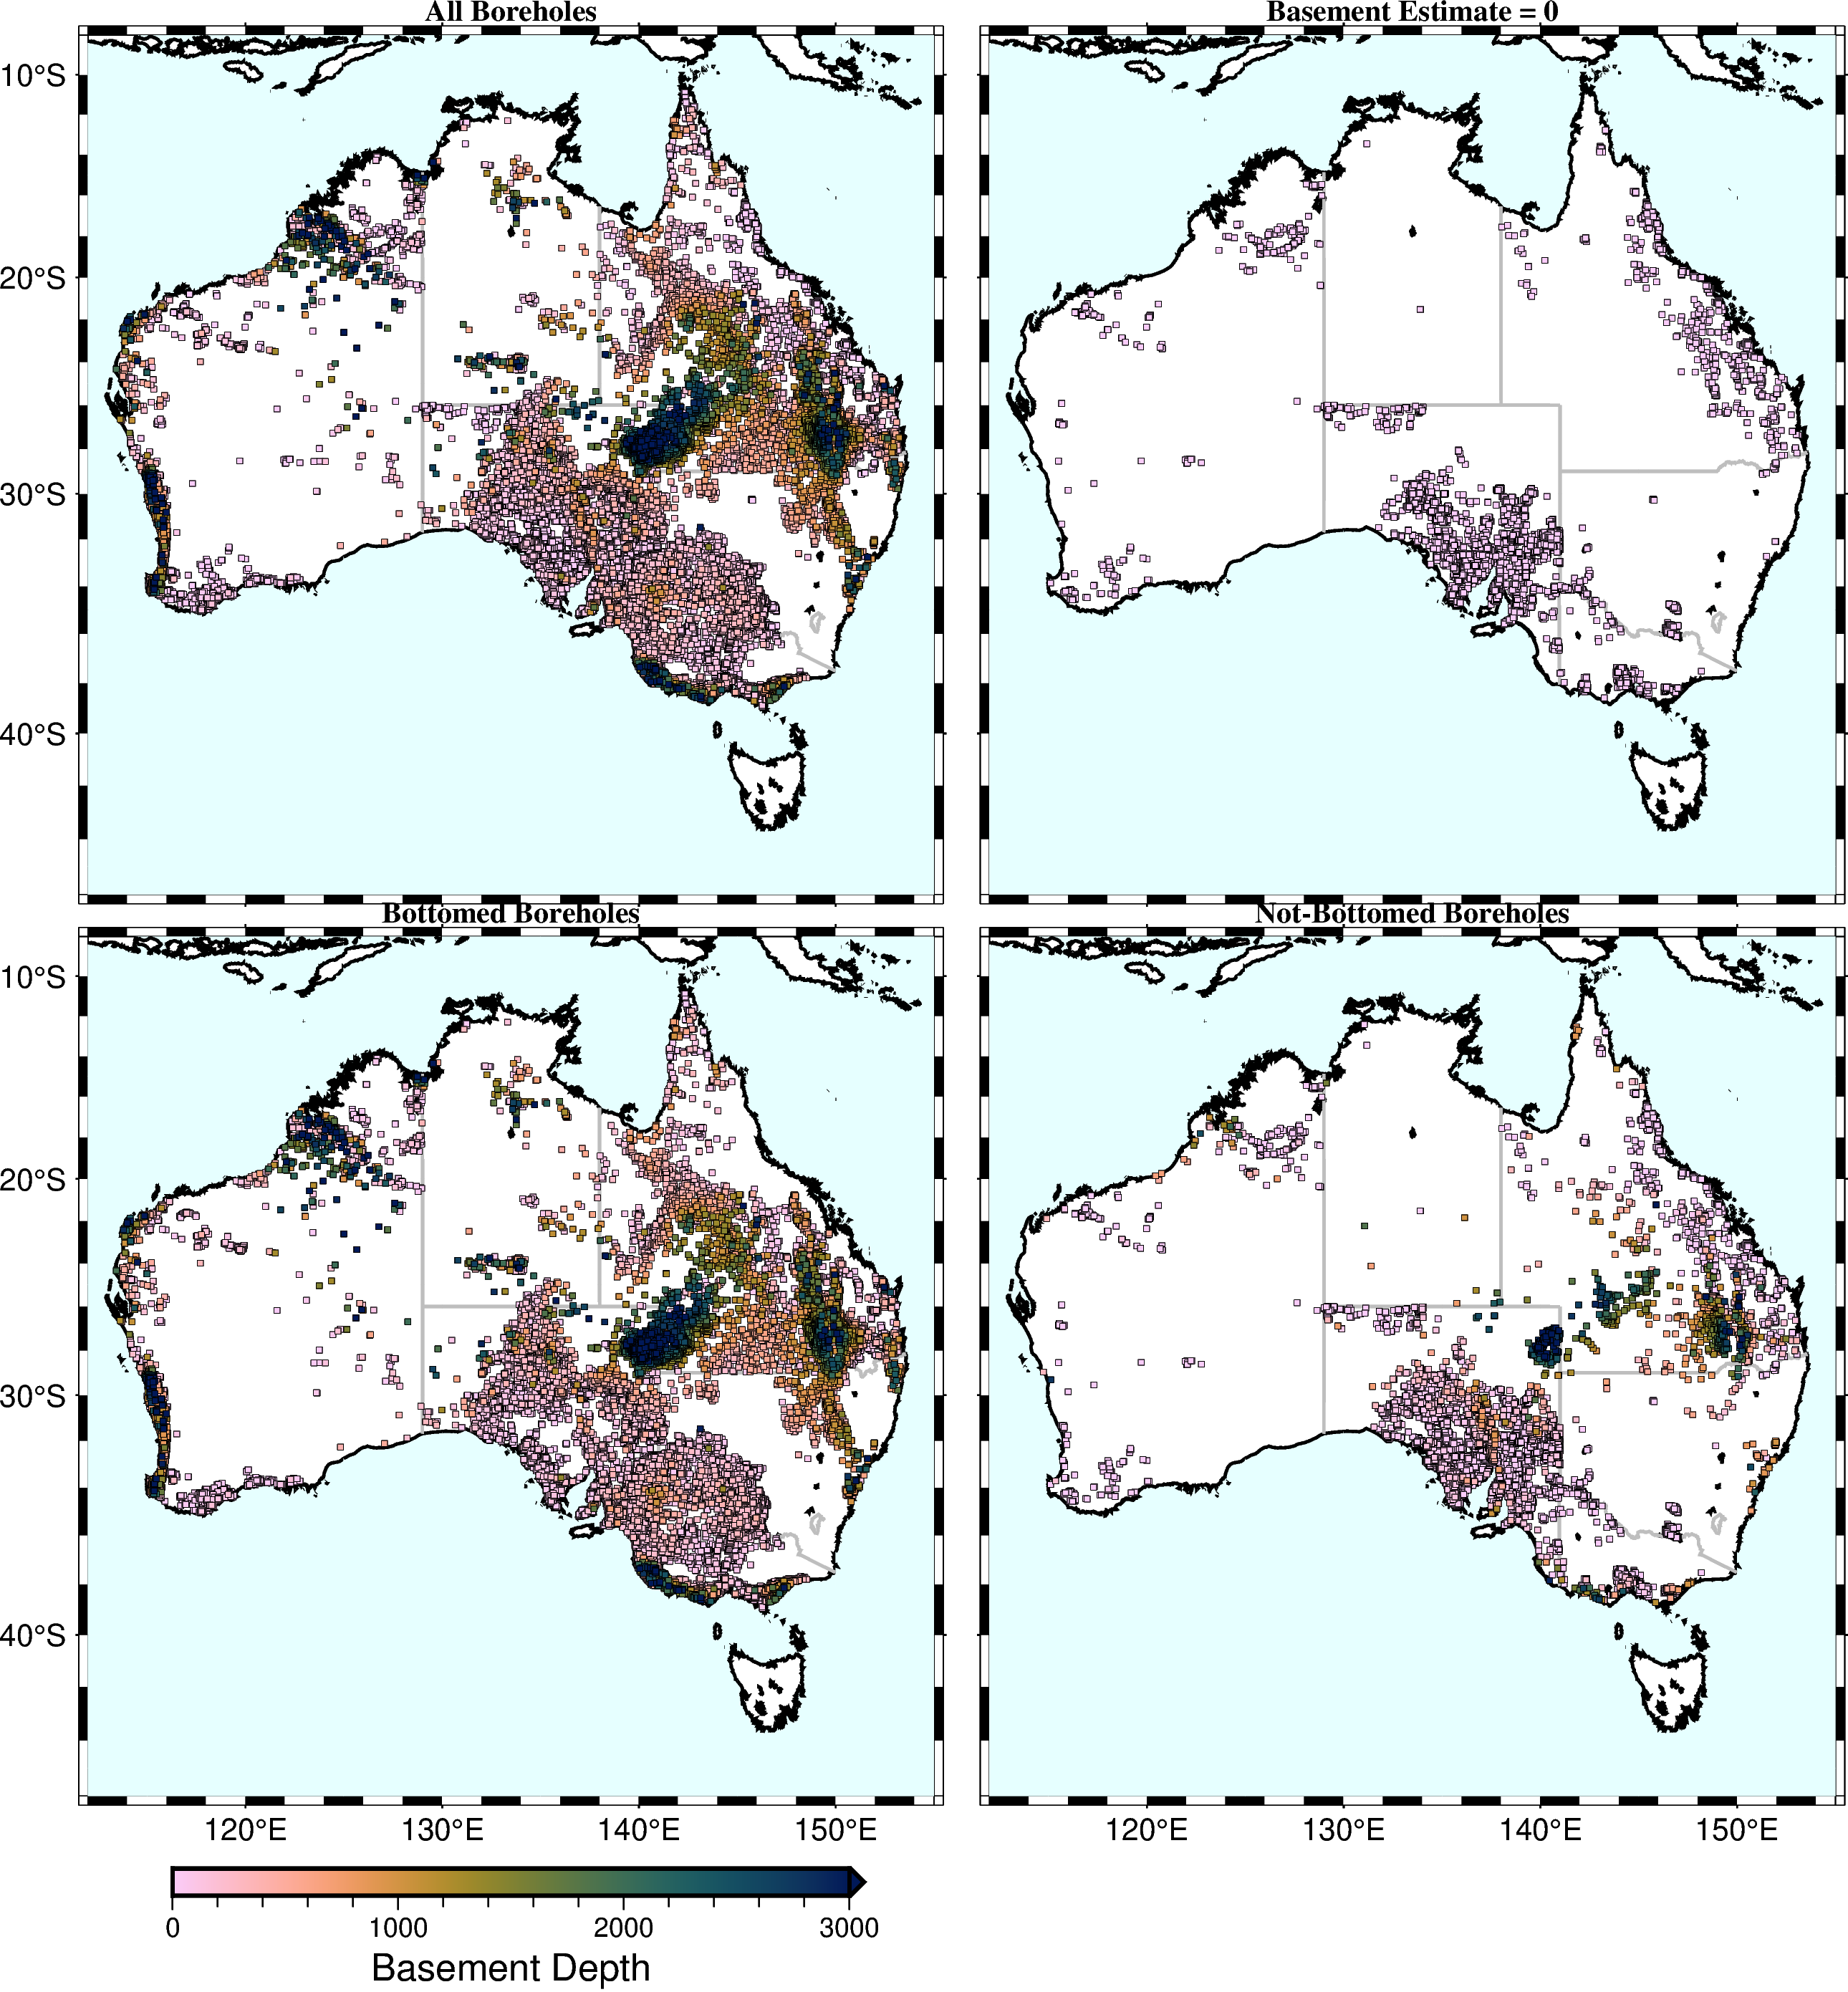

In [ ]:
fig = pygmt.Figure()
pygmt.config(FONT_TITLE="10p,5", MAP_TITLE_OFFSET="-10p")
region = [112, 155, -46, -8]
ln_min, ln_max, lt_min, lt_max = region
fig_width = 10
projection = (
    f"M{int(np.mean([ln_min, ln_max]))}/{int(np.mean([lt_min, lt_max]))}/{fig_width}c"
)
pygmt.makecpt(
    cmap="batlow",
    series=[0, round(np.percentile(boreholes.BASEMENT_DEPTH, 99), -3)],
    reverse=True,
)

subsets = {
    "All Boreholes": boreholes,
    "Basement Estimate = 0": boreholes[boreholes["BASEMENT_DEPTH"] == 0],
    "Bottomed Boreholes": boreholes[boreholes["BOTTOM"] == True],
    "Not-Bottomed Boreholes": boreholes[boreholes["BOTTOM"] == False],
}

with fig.subplot(
    nrows=2,
    ncols=2,
    subsize=(f"{fig_width}c", f"{fig_width}c"),
    sharey="l",
    sharex="b",
    frame="WSne",
):
    for i, (k, v) in enumerate(subsets.items()):
        fig.basemap(
            region=region, projection=projection, frame=["af", f"+t{k}"], panel=i
        )
        fig.coast(
            region=region,
            projection=projection,
            shorelines=1,
            resolution="i",
            water="#e6ffff",
            borders="2/1p,grey",
            panel=i
        )
        x = v.GDA94_LONGITUDE
        y = v.GDA94_LATITUDE
        fill = v.BASEMENT_DEPTH
        size = np.full_like(fill, 0.1)
        fig.plot(
            region=region,
            projection=projection,
            x=x,
            y=y,
            fill=fill,
            cmap=True,
            style=f"sc",
            pen="0p",
            size=size,
            panel=i
        )


fig.colorbar(
    region=region,
    projection=projection,
    frame=["af+lBasement Depth"],
    position=f"JBC+ef",
)
fig.show()
